In [ ]:
!unzip /content/drive/MyDrive/NMR_Dataset.zip "shapenet/02958343/*" -d /content/NMR_Dataset

Streaming output truncated to the last 5000 lines.
 extracting: /content/NMR_Dataset/02691156/fc2d2df18182df8c82a2a8a82be86fd6/mask/0010.png  
  inflating: /content/NMR_Dataset/02691156/fc2d2df18182df8c82a2a8a82be86fd6/mask/0011.png  
 extracting: /content/NMR_Dataset/02691156/fc2d2df18182df8c82a2a8a82be86fd6/mask/0012.png  
  inflating: /content/NMR_Dataset/02691156/fc2d2df18182df8c82a2a8a82be86fd6/mask/0013.png  
  inflating: /content/NMR_Dataset/02691156/fc2d2df18182df8c82a2a8a82be86fd6/mask/0014.png  
 extracting: /content/NMR_Dataset/02691156/fc2d2df18182df8c82a2a8a82be86fd6/mask/0015.png  
 extracting: /content/NMR_Dataset/02691156/fc2d2df18182df8c82a2a8a82be86fd6/mask/0016.png  
  inflating: /content/NMR_Dataset/02691156/fc2d2df18182df8c82a2a8a82be86fd6/mask/0017.png  
  inflating: /content/NMR_Dataset/02691156/fc2d2df18182df8c82a2a8a82be86fd6/mask/0018.png  
  inflating: /content/NMR_Dataset/02691156/fc2d2df18182df8c82a2a8a82be86fd6/mask/0019.png  
  inflating: /content/NMR_Dat

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import math

# Setup Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on device: {device}")

# CONFIGURATION
# 02958343 = Cars, 02691156 = Airplanes
CATEGORY_ID = "02958343"
DATA_PATH = f"/content/NMR_Dataset/{CATEGORY_ID}"
IMG_SIZE = 64
BATCH_SIZE = 64

Running on device: cuda


In [ ]:
class NMRShapeNetDataset(Dataset):
    def __init__(self, root_dir, img_size=64, split='train'):
        self.root_dir = root_dir
        self.img_size = img_size

        # Get list of objects (folders)
        if not os.path.exists(root_dir):
            raise ValueError(f"Path {root_dir} does not exist. Check your unzip location.")

        all_objects = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])

        # Split 90% train, 10% val
        split_idx = int(len(all_objects) * 0.9)
        if split == 'train':
            self.objects = all_objects[:split_idx]
        else:
            self.objects = all_objects[split_idx:]

        print(f"[{split.upper()}] Loaded {len(self.objects)} objects.")

        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # [-1, 1]
        ])

    def __len__(self):
        return len(self.objects) * 10 # Epoch size multiplier

    def __getitem__(self, idx):
        obj_idx = idx % len(self.objects)
        obj_name = self.objects[obj_idx]
        obj_path = os.path.join(self.root_dir, obj_name)

        # NMR has 24 views (0-23). Pick 2 random ones.
        view_indices = np.random.choice(24, 2, replace=False)
        idx_ref, idx_tgt = view_indices[0], view_indices[1]

        # Load Images
        img_ref = self.transform(Image.open(os.path.join(obj_path, "image",f"{idx_ref:04d}.png")).convert("RGB"))
        img_tgt = self.transform(Image.open(os.path.join(obj_path, "image",f"{idx_tgt:04d}.png")).convert("RGB"))

        # Load Poses
        cams = np.load(os.path.join(obj_path, "cameras.npz"))
        pose_ref = torch.tensor(cams[f'world_mat_{idx_ref}']).float()
        pose_tgt = torch.tensor(cams[f'world_mat_{idx_tgt}']).float()

        # Calculate Relative Pose: T_target * inv(T_ref)
        # This represents the transformation required to move the camera from Ref to Target
        pose_rel = torch.matmul(pose_tgt, torch.inverse(pose_ref))

        return {
            "ref_img": img_ref,
            "target_img": img_tgt,
            "relative_pose": pose_rel.view(-1) # Flatten 4x4 -> 16
        }

# Initialize Dataloaders
train_dataset = NMRShapeNetDataset(DATA_PATH, IMG_SIZE, split='train')
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

print("Data Loader Ready.")

[TRAIN] Loaded 6746 objects.
Data Loader Ready.


In [ ]:
# 1. Pose Embedder (MLP)
class PoseEmbedder(nn.Module):
    def __init__(self, raw_pose_dim=16, embed_dim=256):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(raw_pose_dim, embed_dim),
            nn.SiLU(),
            nn.Linear(embed_dim, embed_dim),
        )

    def forward(self, pose):
        return self.mlp(pose)

# 2. Basic Residual Block
class ResBlock(nn.Module):
    def __init__(self, in_c, out_c, emb_dim=256):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, 3, padding=1)
        self.conv2 = nn.Conv2d(out_c, out_c, 3, padding=1)
        self.act = nn.SiLU()
        self.emb_proj = nn.Linear(emb_dim, out_c) # Projects time+pose emb to channels

        if in_c != out_c:
            self.shortcut = nn.Conv2d(in_c, out_c, 1)
        else:
            self.shortcut = nn.Identity()

    def forward(self, x, emb):
        h = self.conv1(self.act(x))

        # Inject Embedding (Time + Pose)
        # We project the embedding and add it to the feature map
        emb_out = self.emb_proj(self.act(emb))
        h = h + emb_out[:, :, None, None]

        h = self.conv2(self.act(h))
        return h + self.shortcut(x)

# 3. The Main U-Net
class ConditionalUNet(nn.Module):
    def __init__(self, in_channels=3, base_dim=64, pose_dim=16):
        super().__init__()

        # Input takes 6 channels: 3 (Noisy Target) + 3 (Reference)
        self.conv_in = nn.Conv2d(in_channels * 2, base_dim, 3, padding=1)

        # Time Embedding
        self.time_mlp = nn.Sequential(
            nn.Linear(base_dim, base_dim * 4),
            nn.SiLU(),
            nn.Linear(base_dim * 4, base_dim * 4),
        )

        # Pose Embedding
        self.pose_mlp = PoseEmbedder(raw_pose_dim=pose_dim, embed_dim=base_dim * 4)

        # Encoder
        self.down1 = ResBlock(base_dim, base_dim, emb_dim=base_dim*4)
        self.down2 = ResBlock(base_dim, base_dim*2, emb_dim=base_dim*4)
        self.down3 = ResBlock(base_dim*2, base_dim*4, emb_dim=base_dim*4)

        # Bottleneck
        self.mid = ResBlock(base_dim*4, base_dim*4, emb_dim=base_dim*4)

        # Decoder
        self.up3 = ResBlock(base_dim*8, base_dim*2, emb_dim=base_dim*4) # concat 4+4 -> 8
        self.up2 = ResBlock(base_dim*4, base_dim, emb_dim=base_dim*4)   # concat 2+2 -> 4
        self.up1 = ResBlock(base_dim*2, base_dim, emb_dim=base_dim*4)   # concat 1+1 -> 2

        self.out = nn.Conv2d(base_dim, 3, 1)

    def get_timestep_embedding(self, timesteps, embedding_dim):
        # Sinusoidal embedding
        half_dim = embedding_dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, dtype=torch.float32, device=timesteps.device) * -emb)
        emb = timesteps[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
        if embedding_dim % 2 == 1:
            emb = torch.nn.functional.pad(emb, (0, 1, 0, 0))
        return emb

    def forward(self, x_noisy, t, ref_img, relative_pose):
        # 1. Concatenate Input (Channel-wise)
        x = torch.cat([x_noisy, ref_img], dim=1)
        x = self.conv_in(x)

        # 2. Process Embeddings
        t_emb = self.get_timestep_embedding(t, 64)
        t_emb = self.time_mlp(t_emb)
        p_emb = self.pose_mlp(relative_pose)

        # Fuse Embeddings (Simple Addition)
        emb = t_emb + p_emb

        # 3. U-Net Pass
        x1 = self.down1(x, emb)
        x2 = self.down2(F.avg_pool2d(x1, 2), emb)
        x3 = self.down3(F.avg_pool2d(x2, 2), emb)

        x_mid = self.mid(F.avg_pool2d(x3, 2), emb)

        x_up3 = self.up3(torch.cat([F.interpolate(x_mid, scale_factor=2), x3], dim=1), emb)
        x_up2 = self.up2(torch.cat([F.interpolate(x_up3, scale_factor=2), x2], dim=1), emb)
        x_up1 = self.up1(torch.cat([F.interpolate(x_up2, scale_factor=2), x1], dim=1), emb)

        return self.out(x_up1)

print("Model Architecture Defined.")

Advanced U-Net with Attention and GroupNorm is Ready.


In [ ]:
# Setup Training
EPOCHS = 20
LR = 2e-4

model = ConditionalUNet().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
criterion = nn.MSELoss()

# Diffusion Schedules
TIMESTEPS = 1000
betas = torch.linspace(0.0001, 0.02, TIMESTEPS).to(device)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)

print("Starting Training...")

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for batch in pbar:
        # Move data to GPU
        ref = batch['ref_img'].to(device)
        target = batch['target_img'].to(device)
        pose = batch['relative_pose'].to(device)

        # 1. Sample random timesteps
        t = torch.randint(0, TIMESTEPS, (ref.shape[0],), device=device).long()

        # 2. Add Noise to Target
        noise = torch.randn_like(target)
        sqrt_alpha_t = torch.sqrt(alphas_cumprod[t])[:, None, None, None]
        sqrt_one_minus_alpha_t = torch.sqrt(1. - alphas_cumprod[t])[:, None, None, None]
        x_noisy = sqrt_alpha_t * target + sqrt_one_minus_alpha_t * noise

        # 3. Predict Noise
        # Note: We pass Reference Image and Pose as conditions
        noise_pred = model(x_noisy, t, ref, pose)

        # 4. Optimization
        loss = criterion(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        pbar.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1} Finished. Avg Loss: {epoch_loss / len(train_loader):.5f}")

    # Save Model every 5 epochs
    if (epoch+1) % 5 == 0:
        torch.save(model.state_dict(), f"3dim_model_epoch_{epoch+1}.pth")
        print(f"Model saved: 3dim_model_epoch_{epoch+1}.pth")

Starting Training...


Epoch 1/20:   0%|          | 0/1055 [00:00<?, ?it/s]

Epoch 1 Finished. Avg Loss: 0.04505


Epoch 2/20:   0%|          | 0/1055 [00:00<?, ?it/s]

Exception ignored in: <function NpzFile.__del__ at 0x7ff74c703a60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/numpy/lib/_npyio_impl.py", line 226, in __del__
    self.close()
  File "/usr/local/lib/python3.12/dist-packages/numpy/lib/_npyio_impl.py", line 221, in close
    self.fid.close()
KeyboardInterrupt: 
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff72bf96660>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1618, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.12/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/popen_fork.py", line 40, in wait
    

KeyboardInterrupt: 

In [ ]:
@torch.no_grad()
def generate_autoregressive_sequence(model, initial_ref_img, initial_pose, target_poses):
    """
    Generates a sequence of views.
    For each new view, it uses Stochastic Conditioning (randomly sampling from history).

    Args:
        model: The trained U-Net
        initial_ref_img: [3, 64, 64] Tensor (Frame 0)
        initial_pose: [4, 4] Matrix (Frame 0 pose)
        target_poses: List of [4, 4] Matrices (Poses for Frame 1, Frame 2, ...)
    """
    model.eval()

    # 1. Initialize History
    # We keep everything on CPU to save GPU memory, move to GPU only when needed
    known_images = [initial_ref_img.cpu()]
    known_poses = [initial_pose.cpu()]

    generated_sequence = []

    print(f"Starting generation of {len(target_poses)} frames...")

    # 2. Loop through each target frame we want to generate
    for frame_idx, target_pose in enumerate(target_poses):

        # Prepare for generation
        target_pose = target_pose.to(device)
        x = torch.randn(1, 3, 64, 64).to(device) # Start with pure noise

        # 3. The Denoising Loop (1000 steps)
        for i in tqdm(reversed(range(TIMESTEPS)), desc=f"Gen Frame {frame_idx+1}", leave=False):
            t = torch.tensor([i]).to(device)

            # --- STOCHASTIC CONDITIONING MAGIC STARTS HERE ---

            # A. Randomly pick ONE index from our history
            # If we have 3 known frames, pick 0, 1, or 2.
            hist_idx = np.random.randint(0, len(known_images))

            # B. Grab that specific image and pose
            selected_ref_img = known_images[hist_idx].unsqueeze(0).to(device) # [1, 3, 64, 64]
            selected_ref_pose = known_poses[hist_idx].to(device)              # [4, 4]

            # C. Calculate Relative Pose dynamically
            # "How do I get from the History Frame to the Current Target?"
            # Relative = Target * Inverse(SelectedHistory)
            pose_rel = torch.matmul(target_pose, torch.inverse(selected_ref_pose))
            pose_flat = pose_rel.view(1, -1) # Flatten to [1, 16]

            # --- MAGIC ENDS HERE ---

            # Standard Diffusion Step
            noise_pred = model(x, t, selected_ref_img, pose_flat)

            alpha = alphas[i]
            alpha_cumprod = alphas_cumprod[i]
            beta = betas[i]

            if i > 0:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)

            x = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_cumprod))) * noise_pred) + torch.sqrt(beta) * noise

        # 4. Save the result to History
        result_img = x.squeeze(0).cpu() # Move back to CPU

        known_images.append(result_img)       # Add to pool of references
        known_poses.append(target_pose.cpu()) # Add pose to pool

        generated_sequence.append(result_img)

    return generated_sequence

orignal

[VAL] Loaded 750 objects.
Generating video sequence...
Starting generation of 8 frames...


Gen Frame 1: 0it [00:00, ?it/s]

Gen Frame 2: 0it [00:00, ?it/s]

Gen Frame 3: 0it [00:00, ?it/s]

Gen Frame 4: 0it [00:00, ?it/s]

Gen Frame 5: 0it [00:00, ?it/s]

Gen Frame 6: 0it [00:00, ?it/s]

Gen Frame 7: 0it [00:00, ?it/s]

Gen Frame 8: 0it [00:00, ?it/s]

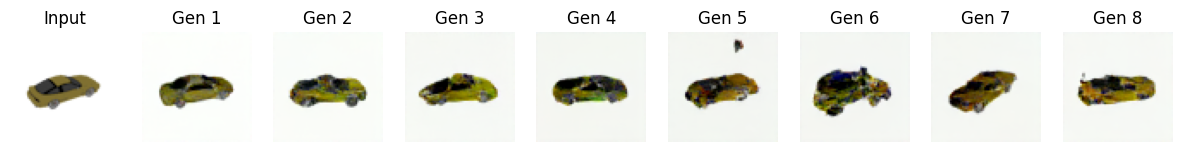

In [ ]:
# 1. Helper to create rotation matrices
def get_rotation_matrix(angle_rad):
    # Simple rotation around Y-axis
    c, s = np.cos(angle_rad), np.sin(angle_rad)
    # This is a standard Y-rotation matrix
    rot = torch.tensor([
        [c, 0, s, 0],
        [0, 1, 0, 0],
        [-s, 0, c, 0],
        [0, 0, 0, 1]
    ]).float()
    return rot

# 2. Setup the Input
# Get a validation car
val_dataset = NMRShapeNetDataset(DATA_PATH, split='val')
item = val_dataset[0]

start_img = item['ref_img'] # The input image
start_pose = torch.eye(4)   # Assume input is at origin (Identity)

# 3. Create Trajectory
# We want to rotate 360 degrees in 8 steps
frames_to_gen = 8
angles = np.linspace(0, 2*np.pi, frames_to_gen + 1)[1:] # Skip 0 (the start)
target_poses = [get_rotation_matrix(a) for a in angles]

# 4. Run the Stochastic Generation
print("Generating video sequence...")
sequence = generate_autoregressive_sequence(model, start_img, start_pose, target_poses)

# 5. Visualize
fig, axes = plt.subplots(1, frames_to_gen + 1, figsize=(15, 3))

# Show Original
axes[0].imshow(start_img.permute(1, 2, 0) * 0.5 + 0.5)
axes[0].set_title("Input")
axes[0].axis('off')

# Show Generated
for i, img in enumerate(sequence):
    axes[i+1].imshow(img.permute(1, 2, 0) * 0.5 + 0.5)
    axes[i+1].set_title(f"Gen {i+1}")
    axes[i+1].axis('off')

plt.show()